<a href="https://colab.research.google.com/github/epigos/learning-pytorch/blob/master/notebooks/08_Deep_Convolutional_Generative_Adversarial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This notebook implement a GAN architecture based on the DCGAN paper: https://arxiv.org/pdf/1511.06434.pdf

The architecture includes:

- A generator network, which maps a latent vector (list of numbers) of some fixed dimension to images of some shape. In our implementation, the shape is (3, 64, 64)
- A discriminator network, which takes as input an image generated by the generator or from the actual dataset, and maps to a score estimating if the input image is real or fake.

In [1]:
from collections import defaultdict, deque
import math
import time
import copy
import itertools
import warnings
from datetime import datetime
import os
warnings.filterwarnings('ignore')

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import save_image
import torchvision.models as models
import torchvision.utils as vutils

from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available(): print('Device name:', torch.cuda.get_device_name())

Device name: Tesla P100-PCIE-16GB


# Load the data

In [3]:
BATCH_SIZE = 128
IMAGE_SIZE = 64

In [4]:
transform_image = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.CIFAR10('./dataset/', transform=transform_image, download=True)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Extracting ./dataset/cifar-10-python.tar.gz to ./dataset/


In [5]:
print(f"Number of training images: {len(dataset)}")
print(f"Size of each image: {dataset[0][0].size()}")

Number of training images: 50000
Size of each image: torch.Size([3, 64, 64])


## show some images

In [6]:
def imshow(img, ax=None, unnormalize=False, **kwargs):
    if not ax:
        _, ax = plt.subplots()

    if unnormalize:
        img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray', **kwargs)
    plt.axis('off')
    plt.show()

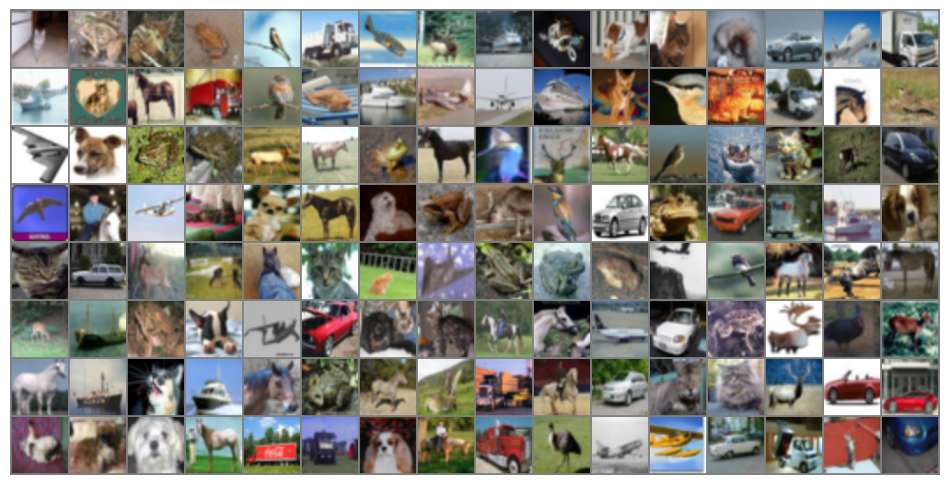

In [7]:
# get some random training images
data_iter = iter(data_loader)
sample_images, labels = data_iter.next()
# show images
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
grid = torchvision.utils.make_grid(sample_images, nrow=int(BATCH_SIZE/8))
imshow(grid, ax=ax, unnormalize=True)

# Define the Model

## Define model parameters

In [8]:
#Size of latnet vector
nz = 100
# Filter size of generator
ngf = 64
# Filter size of discriminator
ndf = 64
# Output image channels
nc = 3

## Weight Initialization

Instead of using the same random weights, we initialize the model with weights as defined in the paper. The following is the weight initialization code:

In [9]:
def weights_inititialisation(m):
   class_name = m.__class__.__name__
   if class_name.find('Conv') != -1:
       m.weight.data.normal_(0.0, 0.02)
   elif class_name.find('BatchNorm') != -1:
       m.weight.data.normal_(1.0, 0.02)
       m.bias.data.fill_(0)

## The Generator model

In [10]:
class Generator(nn.Module):

    def __init__(self, latent_size, filter_size, out_channels):
        super().__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_size, filter_size * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(filter_size * 8),
            nn.ReLU(True),
            # state size. (filter_size*8) x 4 x 4
            nn.ConvTranspose2d(filter_size * 8, filter_size * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(filter_size * 4),
            nn.ReLU(True),
            # state size. (filter_size*4) x 8 x 8
            nn.ConvTranspose2d(filter_size * 4, filter_size * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(filter_size * 2),
            nn.ReLU(True),
            # state size. (filter_size*2) x 16 x 16
            nn.ConvTranspose2d(filter_size * 2, filter_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(filter_size),
            nn.ReLU(True),
            # state size. (filter_size) x 32 x 32
            nn.ConvTranspose2d(filter_size, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            # state size. (out_channels) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output

In [11]:
# view generator model
netG = Generator(nz, ngf, nc)
netG.apply(weights_inititialisation)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [12]:
# test output
noise = torch.FloatTensor(BATCH_SIZE, nz, 1, 1)
out = netG(noise)
print(out.shape)

torch.Size([128, 3, 64, 64])


## The Discriminator model

In [13]:
class Discriminator(nn.Module):

    def __init__(self, in_channels, latent_size, filter_size):
        super().__init__()
        self.main = nn.Sequential(
            # input is (in_channels) x 64 x 64
            nn.Conv2d(in_channels, filter_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (filter_size) x 32 x 32
            nn.Conv2d(filter_size, filter_size * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(filter_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (filter_size*2) x 16 x 16
            nn.Conv2d(filter_size * 2, filter_size * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(filter_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (filter_size*4) x 8 x 8
            nn.Conv2d(filter_size * 4, filter_size * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(filter_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (filter_size*8) x 4 x 4
            nn.Conv2d(filter_size * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

In [14]:
# view generator model
netD = Discriminator(nc, nz, ndf)
netD.apply(weights_inititialisation)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [15]:
# test output
rand_img = torch.FloatTensor(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE)
out = netD(rand_img)
# returns a flatten layer
print(out.shape)

torch.Size([128])


## Loss and Optimizer functions

We will define a binary cross-entropy loss and two optimizers, one for the generator and another one for the discriminator, in the following code:



In [16]:
criterion = nn.BCELoss()
optimizerD = torch.optim.Adam(netD.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=2e-4, betas=(0.5, 0.999))

## Train the model

In [17]:
def train(netD, netG, data_loader, epochs=25):
    # initialize D models
    netD = netD.to(device)
    netD.apply(weights_inititialisation)
    # initialize G models
    netG = netG.to(device)
    netG.apply(weights_inititialisation)
    # define random input
    fixed_noise = torch.randn(BATCH_SIZE, nz, 1, 1, device=device)
    real_label = 1
    fake_label = 0

    # training loop
    for epoch in range(1, epochs + 1):
        for i, (inputs, _) in enumerate(data_loader):
            real_cpu = inputs.to(device)
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            # train with real label
            netD.zero_grad()
            batch_size = real_cpu.size(0)
            label = torch.full((batch_size, ), real_label, device=device)

            output = netD(real_cpu)
            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            # train with fake
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)

            output = netD(fake.detach())
            errD_fake = criterion(output, label)
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            output = netD(fake)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()
            
            if i % 100 == 0:
                print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                % (epoch, epochs, i, len(data_loader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
                
                vutils.save_image(real_cpu, './real_samples.png', normalize=True)
                fake = netG(fixed_noise)
                vutils.save_image(fake.detach(), './fake_samples_epoch_%03d.png' % epoch, normalize=True)
    
        # save checkpoints
        torch.save(netG.state_dict(), './netG_epoch_%d.pth' % epoch)
        torch.save(netD.state_dict(), './netD_epoch_%d.pth' % epoch)
    return netG, netD


In [18]:
%time
G, D = train(netD, netG, data_loader)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.39 µs
[1/25][0/391] Loss_D: 1.6903 Loss_G: 3.5194 D(x): 0.3564 D(G(z)): 0.3157 / 0.0437
[1/25][100/391] Loss_D: 0.3772 Loss_G: 10.2139 D(x): 0.8119 D(G(z)): 0.0005 / 0.0014
[1/25][200/391] Loss_D: 0.2330 Loss_G: 4.5732 D(x): 0.9007 D(G(z)): 0.1004 / 0.0139
[1/25][300/391] Loss_D: 0.7374 Loss_G: 4.6791 D(x): 0.8607 D(G(z)): 0.3565 / 0.0172
[2/25][0/391] Loss_D: 0.2777 Loss_G: 7.2432 D(x): 0.9675 D(G(z)): 0.2006 / 0.0011
[2/25][100/391] Loss_D: 0.2858 Loss_G: 5.1307 D(x): 0.9249 D(G(z)): 0.1657 / 0.0093
[2/25][200/391] Loss_D: 0.3964 Loss_G: 3.8983 D(x): 0.8542 D(G(z)): 0.1503 / 0.0314
[2/25][300/391] Loss_D: 0.9279 Loss_G: 5.0037 D(x): 0.5280 D(G(z)): 0.0117 / 0.0178
[3/25][0/391] Loss_D: 0.1691 Loss_G: 4.7594 D(x): 0.9153 D(G(z)): 0.0671 / 0.0128
[3/25][100/391] Loss_D: 0.4653 Loss_G: 4.5378 D(x): 0.8067 D(G(z)): 0.1683 / 0.0195
[3/25][200/391] Loss_D: 0.2905 Loss_G: 3.7877 D(x): 0.8446 D(G(z)): 0.0855 / 0.0377
[3/25][300/391] L

In [19]:
!ls -la ./

total 644076
drwxr-xr-x 1 root root     4096 Jun 20 19:05 .
drwxr-xr-x 1 root root     4096 Jun 20 18:40 ..
drwxr-xr-x 1 root root     4096 Jun 17 16:18 .config
drwxr-xr-x 3 root root     4096 Jun 20 18:44 dataset
-rw-r--r-- 1 root root  1192732 Jun 20 18:45 fake_samples_epoch_001.png
-rw-r--r-- 1 root root  1130036 Jun 20 18:45 fake_samples_epoch_002.png
-rw-r--r-- 1 root root  1059303 Jun 20 18:46 fake_samples_epoch_003.png
-rw-r--r-- 1 root root  1094941 Jun 20 18:47 fake_samples_epoch_004.png
-rw-r--r-- 1 root root  1017017 Jun 20 18:48 fake_samples_epoch_005.png
-rw-r--r-- 1 root root   999394 Jun 20 18:49 fake_samples_epoch_006.png
-rw-r--r-- 1 root root   951266 Jun 20 18:50 fake_samples_epoch_007.png
-rw-r--r-- 1 root root   958361 Jun 20 18:50 fake_samples_epoch_008.png
-rw-r--r-- 1 root root   948103 Jun 20 18:51 fake_samples_epoch_009.png
-rw-r--r-- 1 root root   933099 Jun 20 18:52 fake_samples_epoch_010.png
-rw-r--r-- 1 root root   935652 Jun 20 18:53 fake_samples_epoch_01

## Real images


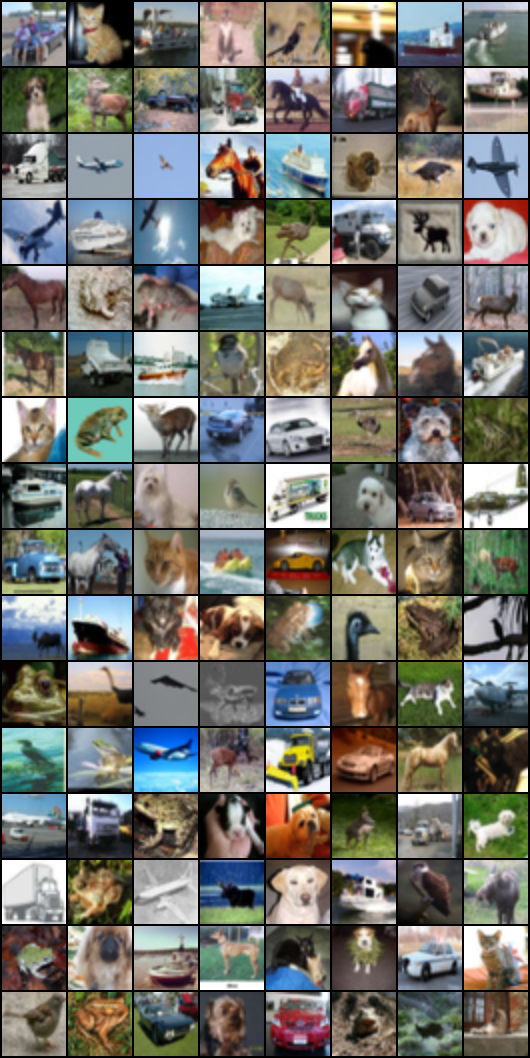

In [20]:
Image.open('./real_samples.png')

## Generated images


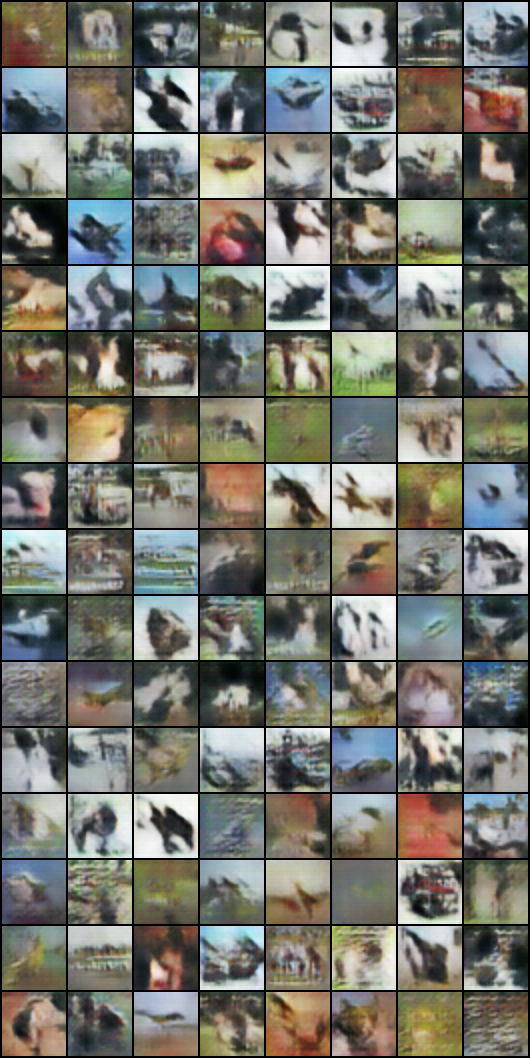

In [21]:
Image.open('./fake_samples_epoch_025.png')